<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>False Political Claim Detection</h1>
    <h3>Entrenamiento y evaluación de los modelos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Importar librerias](#1.-Importar-librerias)
2. [Variables globales y funciones auxiliares](#2.-Variables-globales-y-funciones-auxiliares)
3. [Carga del dataframe](#3.-Carga-del-dataframe)
4. [Selección de las características](#4.-Seleccion-de-las-caracteristicas)
5. [Carga de los datos y división en entrenamiento y test](#5.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
6. [Preprocesado](#6.-Preprocesado)
    * 6.1 [Tratamiento de los textos](#6.1-Tratamiento-de-los-textos)
    * 6.2 [Remuestreo](#6.2-Remuestreo)
7. [Modelos seleccionados](#7.-Modelos-seleccionados)
    * 7.1 [Introducción](#7.1-Introduccion)
    * 7.2 [Asignacion de las variables](#7.2-Asignacion-de-las-variables)
    * 7.3 [Clasificador Random Forest](#7.3-Clasificador-Random-Forest)
8. [Exportar CSV](#8.-Exportar-CSV)
    * 8.1 [Asignacion de las variables](#8.1-Asignacion-de-las-variables)
    * 8.2 [Clasificador Random Forest](#8.2-Clasificador-Random-Forest)
9. [Referencias](#9.-Referencias)

# 1. Importar librerias

In [5]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 2. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [8]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [10]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

# 3. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [13]:
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [15]:
url = "formated/test_exportado.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 4. Seleccion de las caracteristicas

En el siguiente array se muestran todas las caracteristicas por si se decide realizar pruebas con otras *features*.

In [18]:
all_features = [
    # Identificador
    'id',

    # Etiqueta objetivo
    'label',

    # Texto original y procesado
    'statement', 'statement-raw', 'statement-lemmatize', 

    # Features derivados del texto
    'statement-ner', 'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas
    'speaker_grouped', 'speaker_job_grouped', 'state_info_grouped', 'party_group',

    # Resto de las categoricas agrupadas y codificadas
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod',

    # Variables generadas por LLM los null
    'speaker_job-llm', 'speaker_job_cod-llm',
    'state_info-llm', 'state_info_cod-llm',
    'party_affiliation-llm', 'party_affiliation_cod-llm'
]

Se seleccionan todas las categorias menos: 
* ***id***: no aporta ningún valor.
* ***label***: variable a predecir.
* ***statement***: esta *feature* esta por si nos es necesario en algun momento futuro tener el texto sin procesar.
* ***statement-lemmatize***: esta *feature* solo esta para probar en notebooks posteriores si clasifica mejor o peor con las raices de las palabras.
* ***statement-ner***: esta *feature* esta para ver si el clasificador funciona mejor con el NER por separado.
* ***speaker_grouped***, ***speaker_job_grouped***, ***state_info_grouped***, ***party_group***: suponemos que tenemos la misma información ya codificada.
* ***speaker_job-llm***, ***speaker_job_cod-llm***, ***state_info-llm***, ***state_info_cod-llm***, ***party_affiliation-llm***, ***party_affiliation_cod-llm***: esta información ya esta en otras *features*, la diferencia esta en como se tratan los nulos asi que se analizará cual funciona mejor si con LLM o sin ellos durante el apartado de clasificación.

In [20]:
selected_features = [
    # Texto
    'statement-raw',
        
    # Features derivados del texto
    'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas y codificadas
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]

En caso de querer probar si funcionan mejor las de los LLM, se sustituirán por su simil. También si se quiere probar el texto lematizado se sustituira por el *raw*.

De las cuales texto es:

In [23]:
text = 'statement-raw'

Y las que no se corresponden con texto son:

In [25]:
no_text = [
    # Features derivados del texto
    'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas y codificadas
     'speaker_grouped_cod', 'speaker_job_grouped_cod',
     'state_info_grouped_cod', 'party_group_cod'
]

Y de las cuales, numéricas son las siguientes:

In [27]:
numeric_vars = [
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]

# 5. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [30]:
X = df[selected_features] 
y = df['label'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [34]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 6. Preprocesado

Como se menciona en el notebook dedicado al preprocesamiento, primero se tratará el texto, después se reducirá su dimensionalidad con un *TruncatedSVD*, se estandarizarán las variables codificadas mediante un *StandardScaler* y, finalmente, se realizará un remuestreo mediante *SMOTE* y *RandomUnderSampler*. 

En caso de querer probar el caso de preprocesamiento 6, será necesario eliminar el *StandardScaler* junto al *ColumnTransformer*.

## 6.1 Tratamiento de los textos

### 6.1.1 Vectorización

Primero tratamos el texto para los análisis de los modelos.

In [40]:
# Tratamiento del texto para el analisis de los modelos
vect = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1,2))
vect.fit(X_train[text])

X_txt_train = vect.transform(X_train[text])
X_txt_test = vect.transform(X_test[text])

Después para el dataset que se utilizará para subir a Kaggle.

In [42]:
# Tratamiento del texto para Kaggle
vect_final = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1,2))
vect_final.fit(X_train_final[text])

X_txt_tr_final = vect_final.transform(X_train_final[text])
X_txt_te_final = vect_final.transform(X_test_final[text])

### 6.1.2 Reducción de la dimensionalidad

Aplicamos un *SVD* para reducir la dimensionalidad, empezando para los conjuntos de análisis.

In [45]:
svd = TruncatedSVD(n_components=1000, random_state=seed)
svd.fit(X_txt_train)

X_svd_full_train = svd.transform(X_txt_train)
X_svd_full_test = svd.transform(X_txt_test)

Continuando con la de Kaggle.

In [47]:
svd_final = TruncatedSVD(n_components=2000, random_state=seed)
svd_final.fit(X_txt_tr_final)

X_svd_full_tr_final = svd_final.transform(X_txt_tr_final)
X_svd_full_te_final = svd_final.transform(X_txt_te_final)

Nos quedamos solamente con los componentes que nos permitan tener un de ratio de explicabilidad determinado. Primero el de análisis.

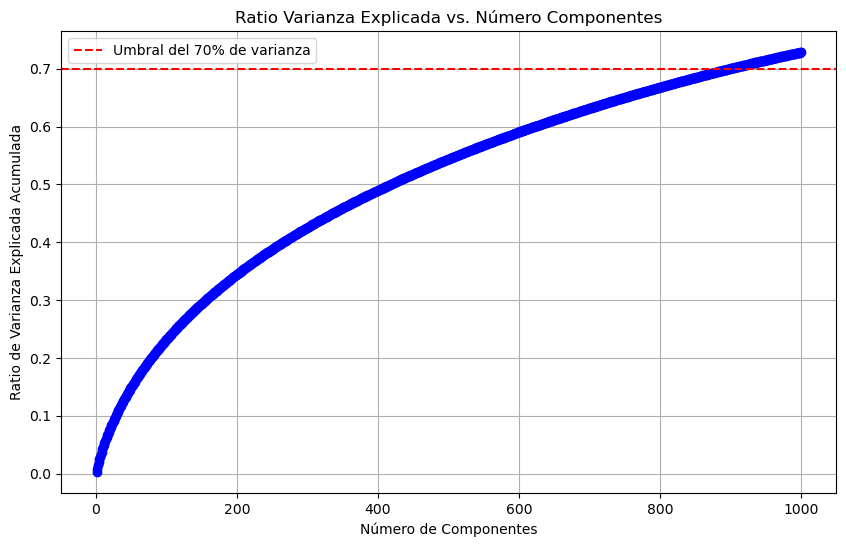

In [49]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(svd.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
         cumulative_variance_ratio, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Ratio de Varianza Explicada Acumulada')
plt.title('Ratio Varianza Explicada vs. Número Componentes')
plt.grid(True)

# Add threshold line
plt.axhline(y=0.7, color='r', linestyle='--', 
            label='Umbral del 70% de varianza')
plt.legend()
plt.show()

Continuando con el de Kaggle.

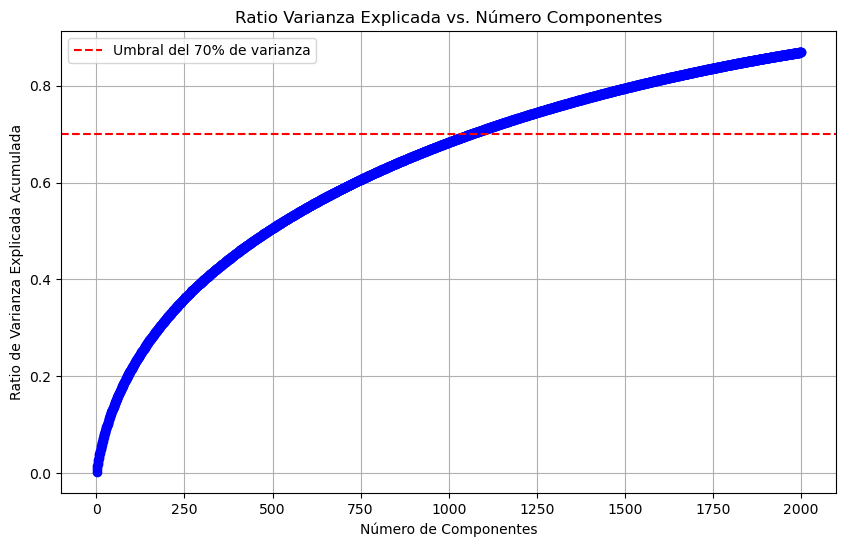

In [51]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio_final = np.cumsum(svd_final.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio_final) + 1), 
         cumulative_variance_ratio_final, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Ratio de Varianza Explicada Acumulada')
plt.title('Ratio Varianza Explicada vs. Número Componentes')
plt.grid(True)

# Add threshold line
plt.axhline(y=0.7, color='r', linestyle='--', 
            label='Umbral del 70% de varianza')
plt.legend()
plt.show()

Y ahora, seleccionamos el número de componentes, así como el desglose que aporta cada uno de ellos al ratio de  explicabilidad. Primero el de análisis.

In [53]:
n_comp = np.argmax(cumulative_variance_ratio >= 0.7) + 1
print(f"Número de componentes seleccionados: {n_comp}")
print(f"Varianza explicada con {n_comp} componentes: "
      f"{cumulative_variance_ratio[n_comp-1]:.4f}")

# Display variance explained by each component
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(svd.explained_variance_ratio_[:n_comp]):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")

Número de componentes seleccionados: 898
Varianza explicada con 898 componentes: 0.7001

Varianza explicada por cada componente:
Componente 1: 0.0023 (0.23%)
Componente 2: 0.0064 (0.64%)
Componente 3: 0.0062 (0.62%)
Componente 4: 0.0051 (0.51%)
Componente 5: 0.0047 (0.47%)
Componente 6: 0.0046 (0.46%)
Componente 7: 0.0043 (0.43%)
Componente 8: 0.0042 (0.42%)
Componente 9: 0.0039 (0.39%)
Componente 10: 0.0038 (0.38%)
Componente 11: 0.0036 (0.36%)
Componente 12: 0.0035 (0.35%)
Componente 13: 0.0034 (0.34%)
Componente 14: 0.0033 (0.33%)
Componente 15: 0.0032 (0.32%)
Componente 16: 0.0032 (0.32%)
Componente 17: 0.0030 (0.30%)
Componente 18: 0.0030 (0.30%)
Componente 19: 0.0030 (0.30%)
Componente 20: 0.0029 (0.29%)
Componente 21: 0.0028 (0.28%)
Componente 22: 0.0028 (0.28%)
Componente 23: 0.0028 (0.28%)
Componente 24: 0.0027 (0.27%)
Componente 25: 0.0027 (0.27%)
Componente 26: 0.0027 (0.27%)
Componente 27: 0.0026 (0.26%)
Componente 28: 0.0026 (0.26%)
Componente 29: 0.0026 (0.26%)
Componente

Y despues el de Kaggle.

In [55]:
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.7) + 1
print(f"Número de componentes seleccionados: {n_comp_final}")
print(f"Varianza explicada con {n_comp_final} componentes: "
      f"{cumulative_variance_ratio_final[n_comp_final-1]:.4f}")

# Display variance explained by each component
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(svd_final.explained_variance_ratio_[:n_comp_final]):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")

Número de componentes seleccionados: 1063
Varianza explicada con 1063 componentes: 0.7000

Varianza explicada por cada componente:
Componente 1: 0.0022 (0.22%)
Componente 2: 0.0061 (0.61%)
Componente 3: 0.0059 (0.59%)
Componente 4: 0.0048 (0.48%)
Componente 5: 0.0044 (0.44%)
Componente 6: 0.0043 (0.43%)
Componente 7: 0.0041 (0.41%)
Componente 8: 0.0038 (0.38%)
Componente 9: 0.0036 (0.36%)
Componente 10: 0.0035 (0.35%)
Componente 11: 0.0034 (0.34%)
Componente 12: 0.0033 (0.33%)
Componente 13: 0.0032 (0.32%)
Componente 14: 0.0031 (0.31%)
Componente 15: 0.0030 (0.30%)
Componente 16: 0.0029 (0.29%)
Componente 17: 0.0028 (0.28%)
Componente 18: 0.0028 (0.28%)
Componente 19: 0.0028 (0.28%)
Componente 20: 0.0027 (0.27%)
Componente 21: 0.0027 (0.27%)
Componente 22: 0.0026 (0.26%)
Componente 23: 0.0026 (0.26%)
Componente 24: 0.0026 (0.26%)
Componente 25: 0.0025 (0.25%)
Componente 26: 0.0025 (0.25%)
Componente 27: 0.0024 (0.24%)
Componente 28: 0.0024 (0.24%)
Componente 29: 0.0024 (0.24%)
Componen

Finalmente, nos quedamos con el conjunto de componentes deseado y lo unificamos con el resto de características. Primero el de análisis.

In [57]:
# Reduccion a las componentes deseadas.
X_svd_train = X_svd_full_train[:, :n_comp]
X_svd_test = X_svd_full_test[:, :n_comp]

# Train
X_svd_train = pd.DataFrame(X_svd_train, columns=[f"svd_{i}" for i in range(X_svd_train.shape[1])])
X_rest_train = X_train[no_text].reset_index(drop=True)

# Test
X_svd_test = pd.DataFrame(X_svd_test, columns=[f"svd_{i}" for i in range(X_svd_test.shape[1])])
X_rest_test = X_test[no_text].reset_index(drop=True)

# Text + Resto de features
X_total_train = pd.concat([X_svd_train, X_rest_train], axis=1)
X_total_test = pd.concat([X_svd_test, X_rest_test], axis=1)

Y después Kaggle.

In [59]:
# Reduccion a las componentes deseadas.
X_svd_tr_final = X_svd_full_tr_final[:, :n_comp_final]
X_svd_te_final = X_svd_full_te_final[:, :n_comp_final]

# Train
X_svd_tr_final = pd.DataFrame(X_svd_tr_final, columns=[f"svd_{i}" for i in range(X_svd_tr_final.shape[1])])
X_rest_tr_final = X_train_final[no_text].reset_index(drop=True)

# Test
X_svd_te_final = pd.DataFrame(X_svd_te_final, columns=[f"svd_{i}" for i in range(X_svd_te_final.shape[1])])
X_rest_te_final = X_test_final[no_text].reset_index(drop=True)

# Text + Resto de features
X_tot_tr_final = pd.concat([X_svd_tr_final, X_rest_tr_final], axis=1)
X_tot_te_final = pd.concat([X_svd_te_final, X_rest_te_final], axis=1)

## 6.2 Remuestreo

### 6.2.1 Estandarizacion

Primero se estandarizan el conjunto para el análisis.

In [63]:
prep = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_total_train) 

X_scaled_train = prep.transform(X_total_train)
X_scaled_test = prep.transform(X_total_test)

Después el de Kaggle.

In [65]:
prep_final = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_tot_tr_final) 

X_scaled_tr_final = prep_final.transform(X_tot_tr_final)
X_scaled_te_final = prep_final.transform(X_tot_te_final)

### 6.2.2 Undersampling

Primero se realiza un undersampling al conjunto para el análisis.

In [68]:
under = RandomUnderSampler(sampling_strategy=0.65, random_state=seed)
X_under, y_under = under.fit_resample(X_scaled_train, y_train)

Después el de Kaggle.

In [70]:
under_final = RandomUnderSampler(sampling_strategy=0.8, random_state=seed)
X_under_final, y_under_final = under_final.fit_resample(X_scaled_tr_final, y_train_final)

### 6.2.3 Oversampling

Primero se realiza un oversampling al conjunto para el análisis.

In [73]:
over = SMOTE(sampling_strategy=0.8, random_state=seed)
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

Después el de Kaggle.

In [75]:
over_final = SMOTE(sampling_strategy=0.9, k_neighbors=5, random_state=seed)
X_res_final, y_res_final = over_final.fit_resample(X_under_final, y_under_final)

# 7. Modelos seleccionados

## 7.1 Introduccion

En el anterior notebook se evaluaron una serie de modelos tanto por F1 score como por ROC-AUC score. Los modelos con mejores resultados para ambas categorías fueron:
* Random Forest.
* GradientBoosting.
* XGBoost.
* LogisticRegression.
* SVC con kernel rbf.

Por lo tanto nos dispondremos a probar dichos modelos a continuación.

## 7.2 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [80]:
X_model = X_resampled
y_model = y_resampled

X_model_test = X_scaled_test
expected = y_test

## 7.3 Clasificador Random Forest

### 7.3.1 Definicion

Definimos el modelo con los hiperparámetros *random_state* fijado y *class_weigth* balanceado. También se escoje *n_jobs* con valor -1 para utilizar todos los procesadores.

In [84]:
model_Forest = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=seed)

### 7.3.2 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [87]:
model_Forest.fit(X_model, y_model)

predicted_Forest = model_Forest.predict(X_model_test)

In [88]:
accuracy_score(expected, predicted_Forest)

0.6262569832402235

### 7.3.3 Null accuracy

Ahora se va a evaluar si  el modelo siempre predice la clase más frecuente.

In [91]:
s_y_test = pd.Series(y_test)
s_y_test.value_counts()

1    1179
0     611
Name: count, dtype: int64

In [92]:
y_test.mean()

0.658659217877095

In [93]:
1 - y_test.mean() 

0.341340782122905

In [94]:
max(y_test.mean(), 1 - y_test.mean())

0.658659217877095

In [95]:
s_y_test.value_counts().head(1) / len(y_test)

1    0.658659
Name: count, dtype: float64

Nuestra exactitud es de 0.626, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 7.3.4 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [99]:
print(confusion_matrix(expected, predicted_Forest))

[[177 434]
 [235 944]]


In [100]:
print(classification_report(expected, predicted_Forest))

              precision    recall  f1-score   support

           0       0.43      0.29      0.35       611
           1       0.69      0.80      0.74      1179

    accuracy                           0.63      1790
   macro avg       0.56      0.55      0.54      1790
weighted avg       0.60      0.63      0.60      1790



Se observa que estamos identificando erroneamente los 0s ya que tenemos un f1-score del 0.74 para los 1s mientras que estamos obteniendo un 0.35 para los 0s

### 7.3.5 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

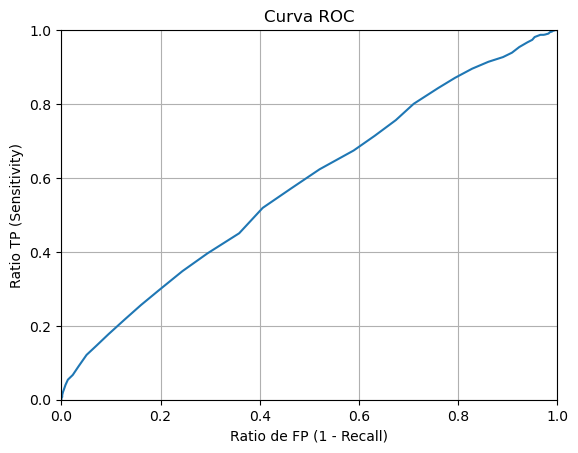

In [104]:
y_pred_prob_Forest = model_Forest.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(expected, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [106]:
thresholds

array([ inf, 0.9 , 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58,
       0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47,
       0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36,
       0.35, 0.34, 0.33, 0.31, 0.29, 0.14])

Como se observa el resultado no es bueno ya que estamos obteniendo practicamente una recta en vez de una curva en forma de 'L' invertida.

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

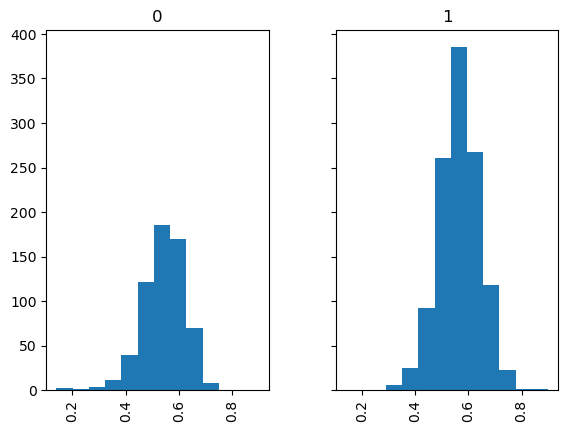

In [109]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.5 aproximandamente (es decir, el valor por defecto).

In [111]:
best_thres_Random = 0.5

evaluate_threshold(best_thres_Random)

Sensitivity: 0.8006785411365565
Recall: 0.28968903436988547


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [113]:
probs_Forest = model_Forest.predict_proba(X_model_test)[:, 1]  
pred_thres_Forest = (probs_Forest >= best_thres_Random).astype(int) 

Se evalua la matriz de confusión.

In [115]:
print(confusion_matrix(expected, pred_thres_Forest))

[[147 464]
 [185 994]]


Y también se analiza el informe de la clasificación.

In [117]:
print(classification_report(expected, pred_thres_Forest))

              precision    recall  f1-score   support

           0       0.44      0.24      0.31       611
           1       0.68      0.84      0.75      1179

    accuracy                           0.64      1790
   macro avg       0.56      0.54      0.53      1790
weighted avg       0.60      0.64      0.60      1790



Obviamente son los mismos, ya que no estamos modificando el umbral realmente.

Finalmente se calcula el valor de AUC.

In [120]:
print(roc_auc_score(expected, predicted_Forest))

0.545183787753221


Se ha obtenido un valor entre 0.5 y 0.6, es decir, el modelo se considerá como fallido o *F*.

### 7.3.6 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [124]:
model_Forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

También creemos que es interesante saber la profundidad media de nuestro modelo Random Forest, para así poder estimar mejor rango de valores en este apartado.

In [126]:
arboles_decision = model_Forest.estimators_

profundidades = [arbol.tree_.max_depth for arbol in arboles_decision]
profundidad_media = np.mean(profundidades)

print(f"Profundidad media de los árboles: {profundidad_media}")

Profundidad media de los árboles: 38.36


Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Además, se ha añadido la librería *time* para saber el tiempo que tardo en realizar la busqueda de mejores parámetros.

Estos hiperparámetros son:
* ***n_estimator***: número de árboles.
* ***max_depth***: máxima profundidad de cada árbol.
* ***min_samples_split***: número de muestras mínimas para dividir un nodo interno.
* ***min_samples_leaf***: número de muestras mínimas de un nodo hoja.
* ***max_features***: número de características a tener en cuenta a la hora de buscar la mejor división.
* ***class_weight***: pesos asignados a las clases.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 7.3.7 Entrenamiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [134]:
params_final_Forest = {
    'class_weight': 'balanced',
    'max_depth': 25,
    'max_features': 50,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 300,
    'n_jobs': -1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [136]:
final_Forest = RandomForestClassifier(**params_final_Forest)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [139]:
final_Forest.fit(X_model, y_model)

predicted_For_opt = final_Forest.predict(X_model_test)

In [140]:
accuracy_score(expected, predicted_For_opt)

0.629608938547486

#### - Null accuracy

La accuracy es similar a la anterior. Además, sigue siendo peor que la *null accuracy*.

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [145]:
print(confusion_matrix(expected, predicted_For_opt))

[[199 412]
 [251 928]]


In [146]:
print(classification_report(expected, predicted_For_opt))

              precision    recall  f1-score   support

           0       0.44      0.33      0.38       611
           1       0.69      0.79      0.74      1179

    accuracy                           0.63      1790
   macro avg       0.57      0.56      0.56      1790
weighted avg       0.61      0.63      0.61      1790



#### - ROC y AUC

Se calcula el ROC y se reajusta el umbral de probabilidad.

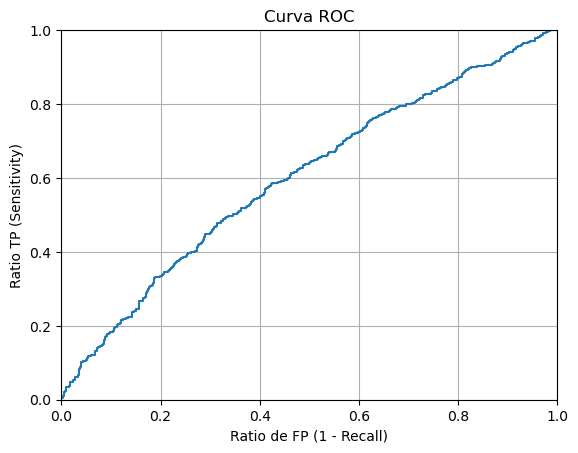

In [149]:
y_pred_prob_Forest = final_Forest.predict_proba(X_model_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [150]:
thresholds

array([       inf, 0.72087463, 0.69409647, 0.69096869, 0.6888998 ,
       0.68806231, 0.68430822, 0.68381416, 0.66848821, 0.66618381,
       0.66524085, 0.66462071, 0.66428692, 0.66398805, 0.65761849,
       0.6549101 , 0.65456067, 0.65449121, 0.6527797 , 0.65206243,
       0.65009672, 0.64934659, 0.64885107, 0.64846503, 0.64779004,
       0.64771564, 0.64567479, 0.64539872, 0.64459377, 0.64413234,
       0.6415937 , 0.64124336, 0.64064498, 0.6397654 , 0.63940314,
       0.63938486, 0.63915958, 0.63881814, 0.63404314, 0.63381731,
       0.63308882, 0.63291237, 0.62821374, 0.62785768, 0.62778789,
       0.62716766, 0.62714466, 0.62662114, 0.62585631, 0.62563059,
       0.62444988, 0.62391734, 0.62345299, 0.62337092, 0.62302119,
       0.62300889, 0.62295852, 0.62217072, 0.62211053, 0.62190987,
       0.62150765, 0.62094192, 0.61904799, 0.61879522, 0.61734205,
       0.61733748, 0.61702116, 0.61681297, 0.61671533, 0.61651649,
       0.6159302 , 0.61563564, 0.61551914, 0.61531592, 0.61450

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

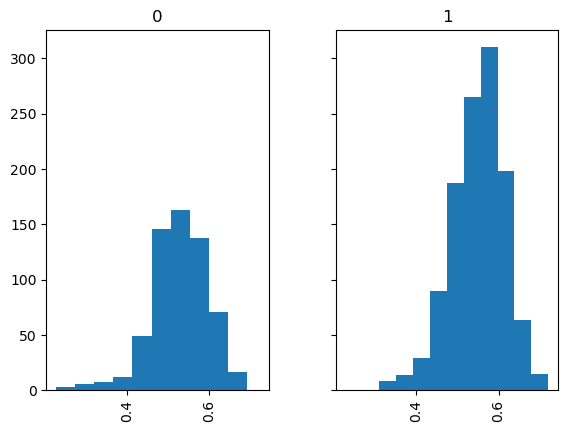

In [151]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [152]:
op_thres_Random = 0.5

evaluate_threshold(op_thres_Random)

Sensitivity: 0.7871077184054284
Recall: 0.32569558101472995


In [153]:
probs_For_opt = final_Forest.predict_proba(X_model_test)[:, 1]  
pred_thres_For_opt = (probs_For_opt >= op_thres_Random).astype(int) 

In [154]:
print(confusion_matrix(expected, pred_thres_For_opt))

[[199 412]
 [251 928]]


In [155]:
print(classification_report(expected, pred_thres_For_opt))

              precision    recall  f1-score   support

           0       0.44      0.33      0.38       611
           1       0.69      0.79      0.74      1179

    accuracy                           0.63      1790
   macro avg       0.57      0.56      0.56      1790
weighted avg       0.61      0.63      0.61      1790



Se obtienen los mismos resultados porque sigue siendo el mejor caso con umbral igual a 0,5.

Se calcula la AUC score.

In [158]:
print(roc_auc_score(expected, predicted_For_opt))

0.5564016497100791


También ha tenido una pequeña mejora, pero sigue en el mismo intervalo. Es decir, sigue siendo un modelo *F*.

### 7.3.8 Conclusiones del modelo

Tal y como esta el modelo no se estan obteniendo buenos resultados debido a la escasez de entradas y la gran cantidad de dimensiones que presenta el dataset. Estamos obteniendo prácticamente los mismos resultados que si decidieramos clasificar al azar.

# 8. Exportar CSV

## 8.1 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [164]:
X_kaggle = X_res_final
y_kaggle = y_res_final

X_kaggle_test = X_scaled_te_final

## 8.2 Clasificador Random Forest

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [167]:
final_Forest.fit(X_kaggle, y_kaggle)

probs_For_final = final_Forest.predict_proba(X_kaggle_test)[:, 1]  
pred_thres_For_final = (probs_For_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [169]:
df_label_Random = pd.DataFrame(pred_thres_For_final, columns=['label'])

In [170]:
df_id = df_test['id'].reset_index(drop=True)

In [171]:
df_final_Random = pd.concat([df_id, df_label_Random], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [173]:
df_final_Random['label'].value_counts()

label
1    2445
0    1391
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [175]:
df_final_Random.to_csv('./submit/random.csv', index=False)

# 9. Referencias

* [ColumnTransformer. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* [GridSearchCV. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [RandomForestClassifier. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [RandomUnderSampler — Version 0.13.0. (s. f.). Imbalance learn.](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)
* [SMOTE — Version 0.13.0. (s. f.). Imbalanced learn.](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
* [StandardScaler. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* [train_test_split. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* [TfidfVectorizer. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [TruncatedSVD. (s. f.). Scikit-learn.](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)